In [3]:
%pip install -r requirements.txt
from IPython.display import clear_output
clear_output()

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from distfit import distfit
import statsmodels as sm

def scatter_plot(x):
    """
    Gráfica de dispersión
    :param x: lista de números pseudoaleatorios
    """
    plt.scatter(x[:-1], x[1:], s=1000/len(x))
    #change dots size to be smaller
    plt.title('Gráfica de dispersión')
    plt.xlabel('xi')
    plt.ylabel('xi+1')
    plt.show()
def corridas_arriba_y_abajo(x, _alfa=0.05):
    """
    Prueba de corridas arriba y abajo
    :param x: lista de números pseudoaleatorios
    """
    n = len(x)
    mu = (2*n-1)/3
    sigma2 = (16*n-29)/90

    S = [1 if x[i] < x[i+1] else 0 for i in range(n-1)]
    Co = sum(abs(S[i] - S[i+1]) for i in range(n-2))
    Z = abs((Co - mu)/sigma2**0.5)
    print('Corridas arriba y abajo')
    print('     Co =', Co)
    print('     Z =', Z)
    print(f'        Z{_alfa} =', stats.norm.ppf(1-_alfa/2))
    print('     H0: Los números son independientes')
    print('     H1: Los números no son independientes')
    if Z < stats.norm.ppf(1-_alfa/2):
        print('     ----Se acepta H0----')
    else:
        print('     ----Se rechaza H0----')
def corridas_arriba_y_abajo_media(x, _alfa = 0.05):
    """
    Prueba de corridas arriba y abajo para la media
    :param x: lista de números pseudoaleatorios
    """
    n = len(x)
    media = 0.5

    S = [1 if x[i] < media else 0 for i in range(n)]
    Co = sum(abs(S[i] - S[i+1]) for i in range(n-1))
    n1 = sum(S)
    n0 = n - n1

    mu = (2*n0*n1)/(n) + 1/2
    sigma2 = (2*n0*n1*(2*n0*n1-n))/(n**2*(n-1))

    Z = abs((Co - mu)/sigma2**0.5)
    print('Corridas arriba y abajo para la media')
    print('     Co =', Co)
    print('     Z =', Z)
    print(f'        Z{_alfa} =', stats.norm.ppf(1-_alfa/2))
    print('     H0: Los numeros son independientes')
    print('     H1: Los numeros no son independientes')
    if Z < stats.norm.ppf(1-_alfa/2):
        print('     ----Se acepta H0----')
    else:
        print('     ----Se rechaza H0----')


In [5]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from distfit import distfit
from pyhomogeneity import pettitt_test

def clean_data():
    data = pd.read_excel('data/base.xlsx')
# Change column names to lowercase and replace spaces with underscores and remove accents
    data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('á', 'a').str.replace('é', 'e').str.replace('í', 'i').str.replace('ó', 'o').str.replace('ú', 'u')
# Convert 'Dia' column to string type
    data['dia'] = data['dia'].astype(str)
# Sacar el día de la semana de día, que es la mitad izquierda antes del espacio
    data['dia_semana'] = data['dia'].apply(lambda x: x.split(' ')[0])
    data['dia_mes'] = data['dia'].apply(lambda x: x.split(' ')[1])
# make 'num_Espera' column with the amount of 'Espera' turned into seconds
    data['num_espera'] = data['espera'].apply(lambda x: x.hour * 60*60 + x.minute*60 + x.second)
# make 'num_duracion' column with the amount of 'duracion' turned into seconds
    data['num_duracion'] = data['duracion'].apply(lambda x: x.hour * 60*60 + x.minute*60 + x.second)
# make 'num_entre_llegadas' column with the amount of 'entre_llegadas' turned into seconds
    data['num_entre_llegadas'] = data['entre_llegadas'].apply(lambda x: x.hour * 60*60 + x.minute*60 + x.second)
# make 'num_llegada' column with the amount of 'llegada' turned into seconds
    data['llegada'] = pd.to_timedelta(data['llegada'])
    data['num_llegada'] = data['llegada'].apply(lambda x: x.total_seconds())
    data["hora_llegada"] = data["llegada"].apply(lambda x: x.total_seconds()//3600)
# make 'num_estado' column with the amount of 'estado', if 'estado' is 'Atendido' then 1, else if 'estado' is 'Pendiente' then 0, else if 'estado' is 'Abandno' then -1
    data['num_estado'] = data['estado'].apply(lambda x: 1 if x == 'Atendido' else 0 if x == 'Pendiente' else -1)
# make 'num_dia_semana' with the day of the week to number, 'Lunes' = 1, 'Martes' = 2, 'Miercoles' = 3, 'Jueves' = 4, 'Viernes' = 5, 'Sabado' = 6, 'Domingo' = 7
    data['num_dia_semana'] = data['dia_semana'].replace({'Lunes': 1, 'Martes': 2, 'Miercoles': 3, 'Jueves': 4, 'Viernes': 5, 'Sabado': 6, 'Domingo': 7})
# make 'num_dia_mes' with the day of the month to number
    data['num_mes'] = data['mes'].replace({'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12})
# make 'num_tiposerv.' with the type of service to number, 1,2,3,4,5.
    data['num_tiposerv.'] = data['tiposerv.'].replace(data['tiposerv.'].unique(), [1,2,3,4,5])
# make 'dia_mes' to numeric
    data['dia_mes'] = data['dia_mes'].astype(int)

#print amount of 'Espera' min or equal to 00:05:00
    print('Porcentaje de clientes que espera menos de 5 minutos: ',data[data['espera'] <= datetime.time(0, 5, 0)].shape[0]/data.shape[0] * 100, '%')
    print('Porcentaje de clientes con Estado Atendido',data[data['estado'] == 'Atendido'].shape[0]/data.shape[0] * 100, '%')
    data.sample(5)
    return data

data = clean_data()
display(data.sample(5))
data.info()

Porcentaje de clientes que espera menos de 5 minutos:  97.84214170320794 %
Porcentaje de clientes con Estado Atendido 91.2762520193861 %


,mes,dia,cliente,llegada,tiposerv.,servidor,inicio_serv.,fin_serv.,estado,espera,...,dia_mes,num_espera,num_duracion,num_entre_llegadas,num_llegada,hora_llegada,num_estado,num_dia_semana,num_mes,num_tiposerv.
8112,Noviembre,Lunes 26,24,0 days 09:32:56,Facturacion,Luisa Diaz,9:33:51,9:40:34,Atendido,00:00:55,...,26,55,403,58,34376.0,9.0,1,1,11,4
801,Abril,Viernes 10,51,0 days 13:59:44,Tecnica,Luis Meza,14:00:59,14:10:46,Atendido,00:01:15,...,10,75,587,581,50384.0,13.0,1,5,4,1
8206,Noviembre,Martes 27,15,0 days 07:23:17,Facturacion,Teresa Rodriguez,7:24:46,7:32:11,Atendido,00:01:29,...,27,89,445,193,26597.0,7.0,1,2,11,4
4142,Septiembre,Viernes 16,17,0 days 08:48:48,Otro,Luis Meza,8:49:49,8:55:05,Atendido,00:01:01,...,16,61,316,536,31728.0,8.0,1,5,9,3
2047,Abril,Viernes 24,18,0 days 09:25:27,Cambio Plan,Teresa Rodriguez,9:26:19,9:28:40,Atendido,00:00:52,...,24,52,141,149,33927.0,9.0,1,5,4,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8666 entries, 0 to 8665
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   mes                 8666 non-null   object         
 1   dia                 8666 non-null   object         
 2   cliente             8666 non-null   int64          
 3   llegada             8666 non-null   timedelta64[ns]
 4   tiposerv.           8666 non-null   object         
 5   servidor            8666 non-null   object         
 6   inicio_serv.        8666 non-null   object         
 7   fin_serv.           8666 non-null   object         
 8   estado              8666 non-null   object         
 9   espera              8666 non-null   object         
 10  duracion            8666 non-null   object         
 11  entre_llegadas      8666 non-null   object         
 12  dia_semana          8666 non-null   object         
 13  dia_mes             8666 non-null

---------------------- Hora: 6 ---------------------------
----------------------------- Independencia -----------------------------


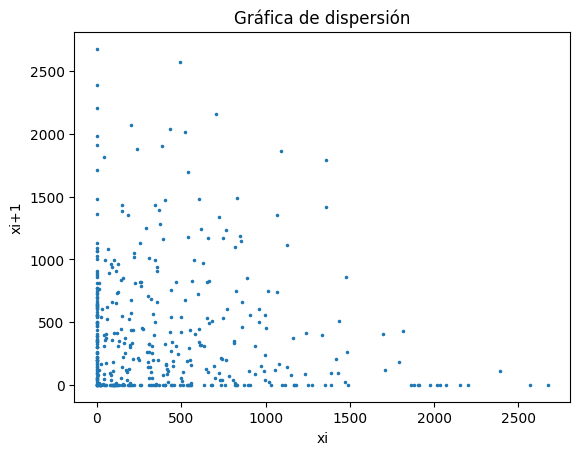

Corridas arriba y abajo
     Co = 278
     Z = 0.1165367143628013
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=162, p=0.9918, U=1980.0, avg=mean(mu1=414.0679012345679, mu2=453.20866141732284))
----------------------------- Bondad de Ajuste -----------------------------


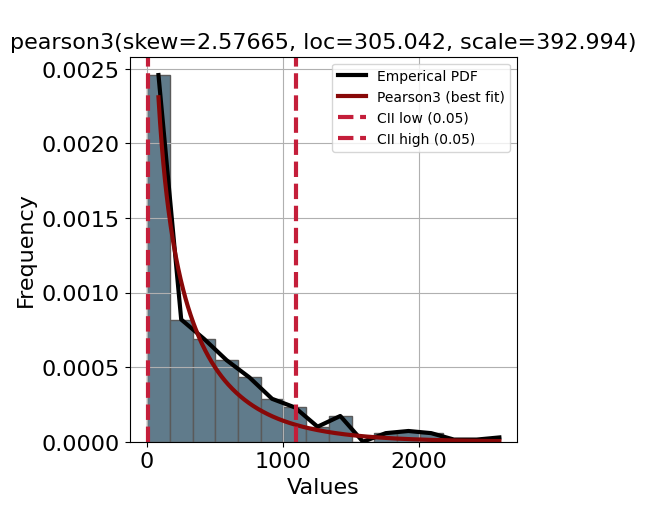

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,pearson3,0.0,305.042094,392.993655,"(2.576651961035645,)","(2.576651961035645, 305.0420944020609, 392.993...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,invgauss,0.0,-33.406816,131.535299,"(3.5836255227356526,)","(3.5836255227356526, -33.40681561576081, 131.5...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,alpha,0.0,-102.504594,181.60286,"(0.004628149196922268,)","(0.004628149196922268, -102.50459419563379, 18...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,recipinvgauss,0.0,-0.0,383.102443,"(1278328.3880859967,)","(1278328.3880859967, -2.457488919473628e-10, 3...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,gamma,0.0,-0.0,459.465799,"(0.861070527489124,)","(0.861070527489124, -3.253691026285462e-26, 45...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,invgamma,0.000008,-0.0,0.0,"(0.2158346302510583,)","(0.2158346302510583, -2.364982544226101e-12, 2...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,mielke,0.000008,-0.0,0.0,"(3.8583182558790723, 0.21212534049657383)","(3.8583182558790723, 0.21212534049657383, -9.1...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000008,2675.0,1.729041,"(0.11053765953612019,)","(0.11053765953612019, 2675.0000000000005, 1.72...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.434459,-0.196777,1,"(0.47290218544421825,)","(0.47290218544421825, -0.19677732851744523, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 7 ---------------------------
----------------------------- Independencia -----------------------------


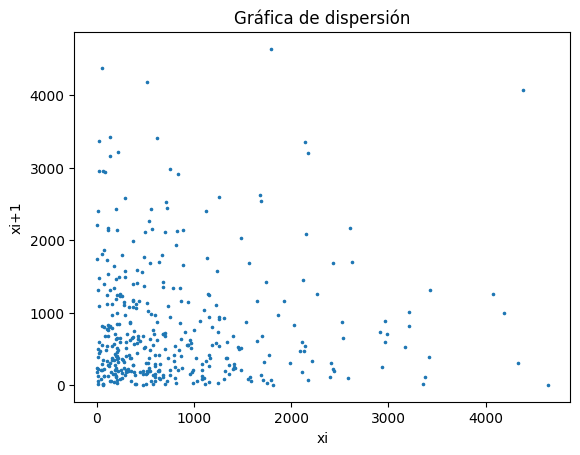

Corridas arriba y abajo
     Co = 275
     Z = 1.5169690897060204
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=85, p=0.22545, U=4603.0, avg=mean(mu1=1018.0235294117647, mu2=756.3851132686084))
----------------------------- Bondad de Ajuste -----------------------------


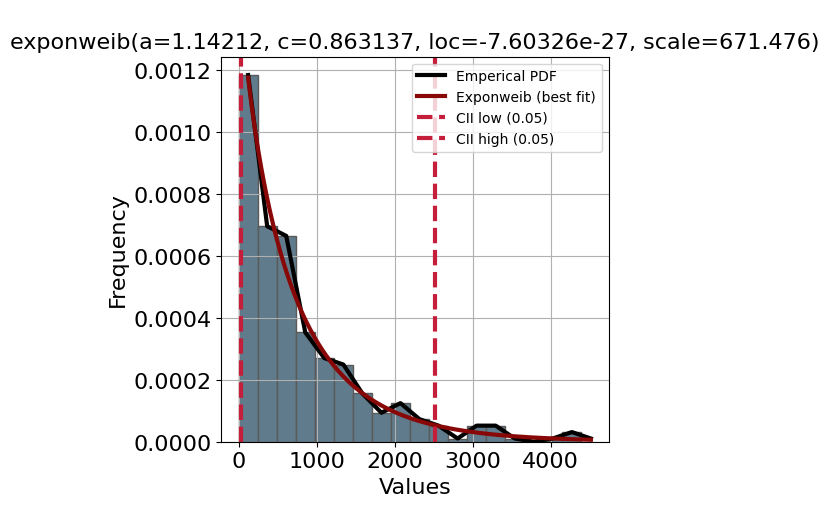

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,exponweib,0.0,-0.0,671.476412,"(1.1421185399102267, 0.8631368131008983)","(1.1421185399102267, 0.8631368131008983, -7.60...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,gamma,0.0,-0.0,820.129186,"(0.9282030318272343,)","(0.9282030318272343, -1.8527913893955673e-28, ...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,pearson3,0.0,785.34842,816.743396,"(2.079951712563998,)","(2.079951712563998, 785.3484202774339, 816.743...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,gengamma,0.0,-0.0,775.936317,"(1.0183597372510516, 0.9396904383235354)","(1.0183597372510516, 0.9396904383235354, -1.47...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,halfgennorm,0.0,-0.0,696.11109,"(0.9046198502108196,)","(0.9046198502108196, -2.6708991787436194e-10, ...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,chi2,0.000003,-0.0,2.127483,"(0.052817803531966204,)","(0.052817803531966204, -6.815804538531484e-24,...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,weibull_max,0.000003,4640.0,1.734984,"(0.09909475233093176,)","(0.09909475233093176, 4640.000000000001, 1.734...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,vonmises,0.477327,-2.760123,1,"(0.07275119083533334,)","(0.07275119083533334, -2.760123215815069, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,mielke,NaN,-305.89089,49.2262,"(203.76728896799972, 1.8230571328026337)","(203.76728896799972, 1.8230571328026337, -305....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 8 ---------------------------
----------------------------- Independencia -----------------------------


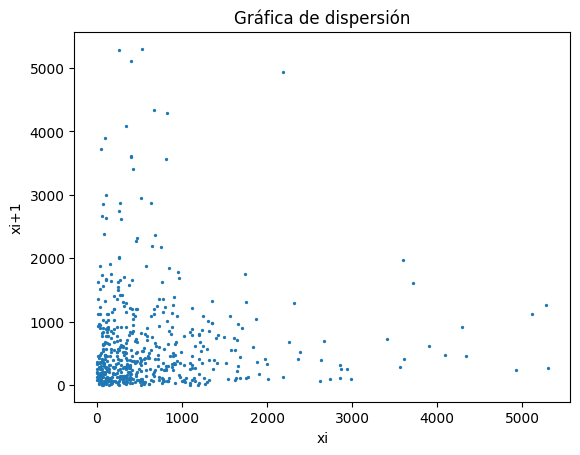

Corridas arriba y abajo
     Co = 364
     Z = 0.5804042547764319
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=116, p=0.2691, U=7052.0, avg=mean(mu1=837.8793103448276, mu2=606.0663507109005))
----------------------------- Bondad de Ajuste -----------------------------


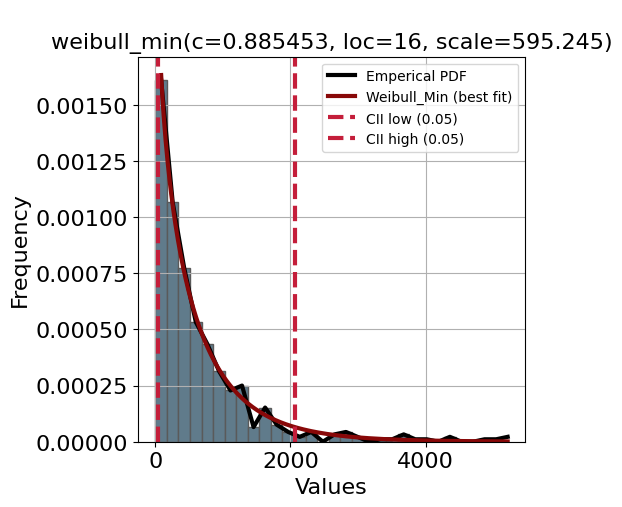

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,weibull_min,0.0,16.0,595.244852,"(0.8854532809021252,)","(0.8854532809021252, 15.999999999999996, 595.2...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,genpareto,0.0,1.0,520.867413,"(0.19459290568783472,)","(0.19459290568783472, 0.9999999999967529, 520....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,exponweib,0.0,0.758365,327.896168,"(1.7520638211213448, 0.667848542660764)","(1.7520638211213448, 0.667848542660764, 0.7583...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,f,0.0,0.999692,528.079583,"(1.9962847739720573, 10.242046232737392)","(1.9962847739720573, 10.242046232737392, 0.999...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,pareto,0.0,-2680.10325,2681.10325,"(5.083521209554245,)","(5.083521209554245, -2680.1032503054344, 2681....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,chi2,0.000005,1.0,2.24068,"(0.048330585638016434,)","(0.048330585638016434, 0.9999999999999998, 2.2...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,gamma,0.000005,1.0,2.250363,"(0.011716837906609143,)","(0.011716837906609143, 0.9999999999999999, 2.2...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000005,5301.0,1.721636,"(0.1040971443271149,)","(0.1040971443271149, 5301.000000000001, 1.7216...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.791054,-0.565596,1,"(0.07035961298844914,)","(0.07035961298844914, -0.5655956328488614, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 9 ---------------------------
----------------------------- Independencia -----------------------------


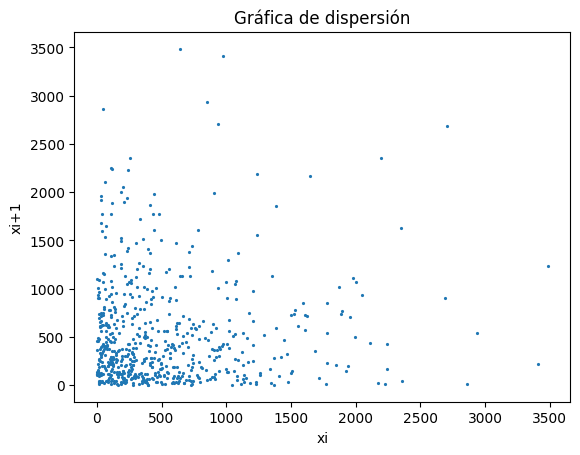

Corridas arriba y abajo
     Co = 408
     Z = 0.28686579466916834
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=299, p=0.34755, U=8098.0, avg=mean(mu1=566.2642140468228, mu2=483.3333333333333))
----------------------------- Bondad de Ajuste -----------------------------


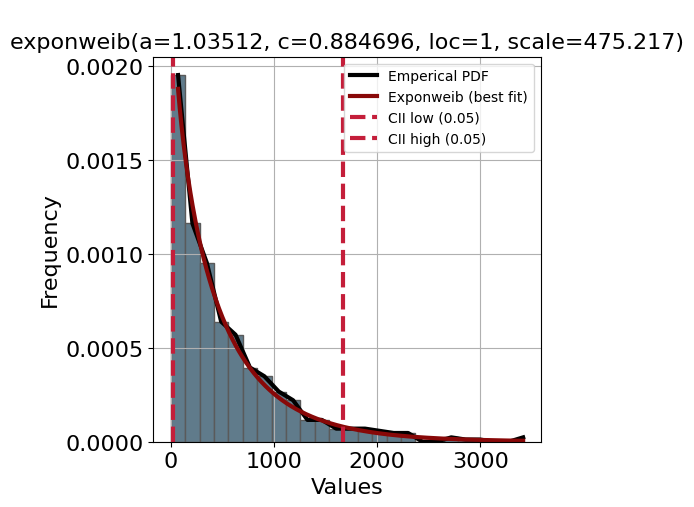

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,exponweib,0.0,1.0,475.217432,"(1.0351237657811323, 0.8846963517929619)","(1.0351237657811323, 0.8846963517929619, 0.999...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,gengamma,0.0,1.0,497.728941,"(1.0063119765106698, 0.9242175961515913)","(1.0063119765106698, 0.9242175961515913, 0.999...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,gamma,0.0,1.0,577.163969,"(0.8973045262465922,)","(0.8973045262465922, 0.9999999999999999, 577.1...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,weibull_min,0.0,1.0,512.265556,"(0.9327079811830484,)","(0.9327079811830484, 0.9999999999999998, 512.2...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,halfgennorm,0.0,1.0,420.216888,"(0.8721795175054212,)","(0.8721795175054212, 0.9999999999979607, 420.2...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,semicircular,0.000005,1403.54898,2083.21918,(),"(1403.5489800328273, 2083.21917960791)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,chi2,0.000007,1.0,2.237889,"(0.0622192716192608,)","(0.0622192716192608, 0.9999999999999999, 2.237...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000007,3484.0,1.733732,"(0.10827459532465497,)","(0.10827459532465497, 3484.000000000001, 1.733...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.630397,-2.323866,1,"(0.03263554589838093,)","(0.03263554589838093, -2.323865543671614, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 10 ---------------------------
----------------------------- Independencia -----------------------------


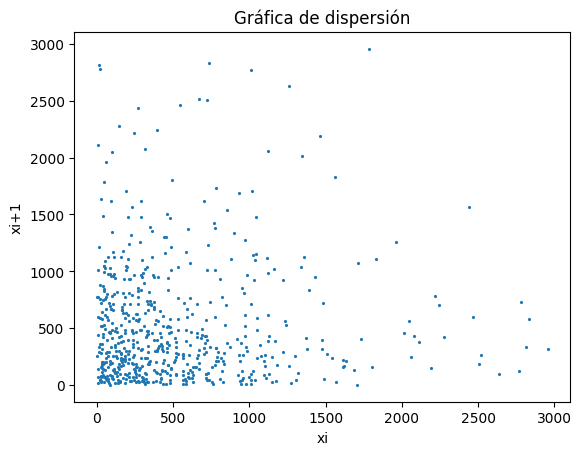

Corridas arriba y abajo
     Co = 441
     Z = 2.934792153843667
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se rechaza H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=True, cp=267, p=0.0058, U=14841.0, avg=mean(mu1=444.1760299625468, mu2=586.6676217765043))
----------------------------- Bondad de Ajuste -----------------------------


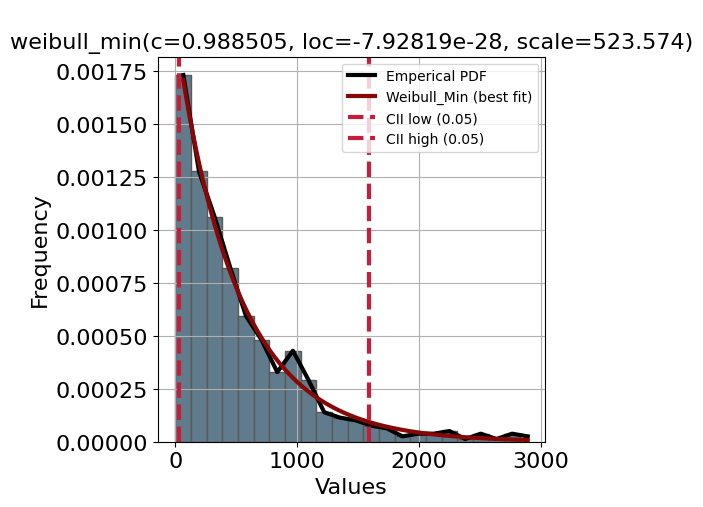

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,weibull_min,0.0,-0.0,523.574383,"(0.9885050842401566,)","(0.9885050842401566, -7.928190477025798e-28, 5...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,pearson3,0.0,522.345594,525.094436,"(2.010524993651181,)","(2.010524993651181, 522.345594145411, 525.0944...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,erlang,0.0,-0.0,527.945197,"(0.9900150043636213,)","(0.9900150043636213, -7.299617005845617e-27, 5...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,beta,0.0,-0.0,44430.990201,"(0.9848100563704218, 82.86519896599458)","(0.9848100563704218, 82.86519896599458, -4.154...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,halfgennorm,0.0,-0.0,510.979014,"(0.9815617388703286,)","(0.9815617388703286, -3.849604810586984e-13, 5...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,alpha,0.000006,-0.87723,2.980734,"(3.697556155696017e-11,)","(3.697556155696017e-11, -0.8772298165676964, 2...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,chi2,0.000007,-0.0,2.119228,"(0.08749525690685961,)","(0.08749525690685961, -8.040924723019244e-25, ...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000008,2957.0,1.737701,"(0.1128736490119385,)","(0.1128736490119385, 2957.000000000001, 1.7377...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.582251,2.47385,1,"(0.04133538979556207,)","(0.04133538979556207, 2.4738497456584163, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 11 ---------------------------
----------------------------- Independencia -----------------------------


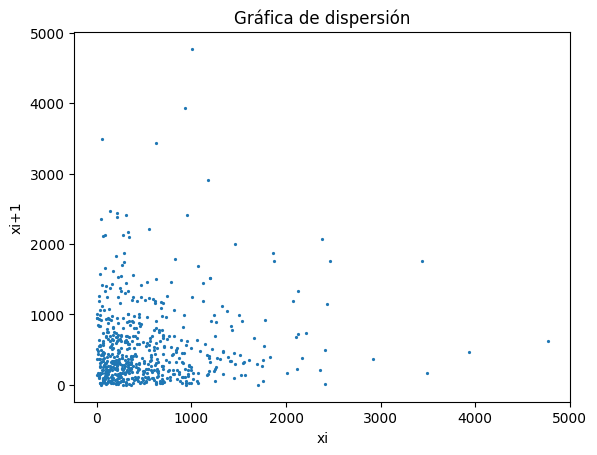

Corridas arriba y abajo
     Co = 414
     Z = 1.5878489561246463
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=278, p=0.30235, U=8037.0, avg=mean(mu1=588.7086330935252, mu2=508.19749216300943))
----------------------------- Bondad de Ajuste -----------------------------


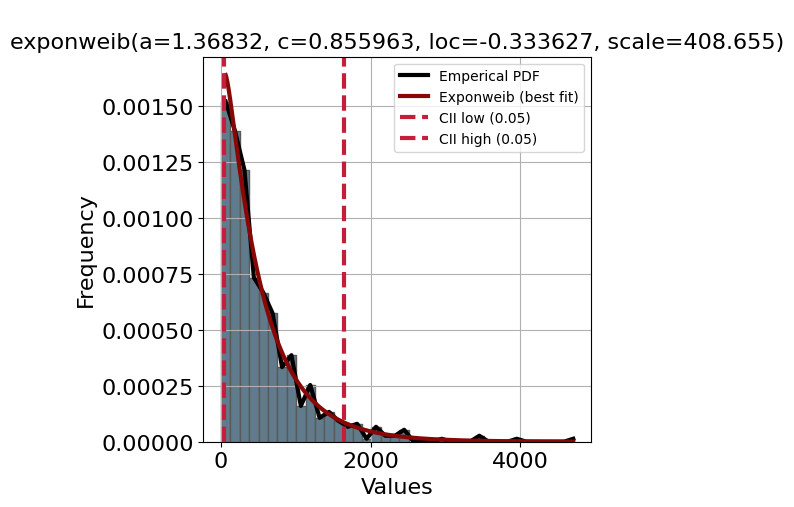

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,exponweib,0.0,-0.333627,408.655375,"(1.368324754591605, 0.8559633044907917)","(1.368324754591605, 0.8559633044907917, -0.333...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,gengamma,0.0,-0.35268,322.626338,"(1.4404573498639552, 0.8188060982695887)","(1.4404573498639552, 0.8188060982695887, -0.35...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,gamma,0.0,-0.032046,529.230148,"(1.0307425409077675,)","(1.0307425409077675, -0.032045795731583865, 52...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,chi2,0.0,-0.032756,264.763559,"(2.0611632572654557,)","(2.0611632572654557, -0.03275635619269139, 264...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,pearson3,0.0,545.688447,537.563843,"(1.9701043058560406,)","(1.9701043058560406, 545.6884472444578, 537.56...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,alpha,0.000006,-0.873751,2.752017,"(1.968869350459584e-11,)","(1.968869350459584e-11, -0.8737512675079998, 2...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,weibull_max,0.000008,4770.0,1.728355,"(0.10392074499519717,)","(0.10392074499519717, 4770.000000000001, 1.728...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,vonmises,1.003299,-1.969132,1,"(0.12278563388440111,)","(0.12278563388440111, -1.9691323265737353, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,mielke,NaN,-265.178593,63.632477,"(178.6329806359201, 2.115096861021793)","(178.6329806359201, 2.115096861021793, -265.17...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 12 ---------------------------
----------------------------- Independencia -----------------------------


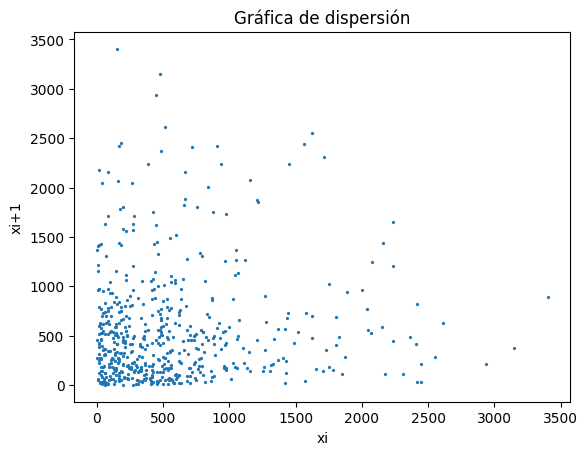

Corridas arriba y abajo
     Co = 379
     Z = 0.330499514372631
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=483, p=0.7998, U=4961.0, avg=mean(mu1=567.3312629399586, mu2=467.3296703296703))
----------------------------- Bondad de Ajuste -----------------------------


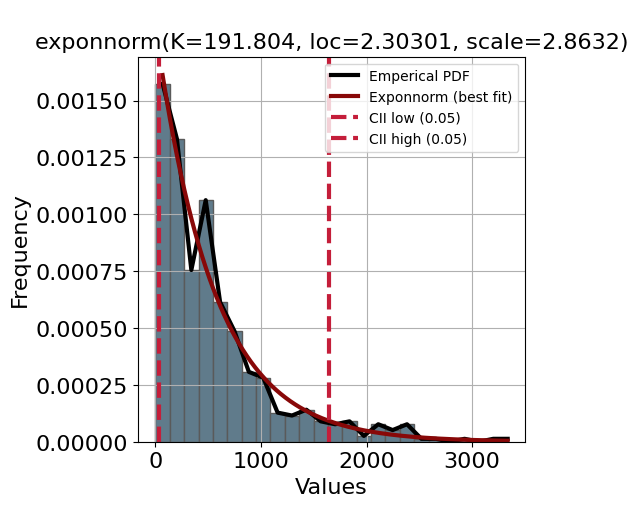

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,exponnorm,0.0,2.303011,2.863202,"(191.80428567740321,)","(191.80428567740321, 2.3030110512234527, 2.863...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,genexpon,0.0,1.0,901.099449,"(1.6369420533739918, 9.627074783933827e-12, 1....","(1.6369420533739918, 9.627074783933827e-12, 1....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,expon,0.0,1.0,550.477352,(),"(1.0, 550.4773519163763)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,mielke,0.0,0.999894,899.540084,"(0.788888704501076, 2.5317492704198603)","(0.788888704501076, 2.5317492704198603, 0.9998...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,burr,0.0,0.99454,851.309006,"(2.5227938101318172, 0.33405235976872905)","(2.5227938101318172, 0.33405235976872905, 0.99...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,uniform,0.000005,1.0,3403.0,(),"(1.0, 3403.0)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,chi2,0.000007,1.0,2.23926,"(0.058601590876691256,)","(0.058601590876691256, 0.9999999999999998, 2.2...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000007,3404.0,1.729948,"(0.11195660100619459,)","(0.11195660100619459, 3404.000000000001, 1.729...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.640756,-0.546781,1,"(0.10945400349618056,)","(0.10945400349618056, -0.5467809027284236, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 13 ---------------------------
----------------------------- Independencia -----------------------------


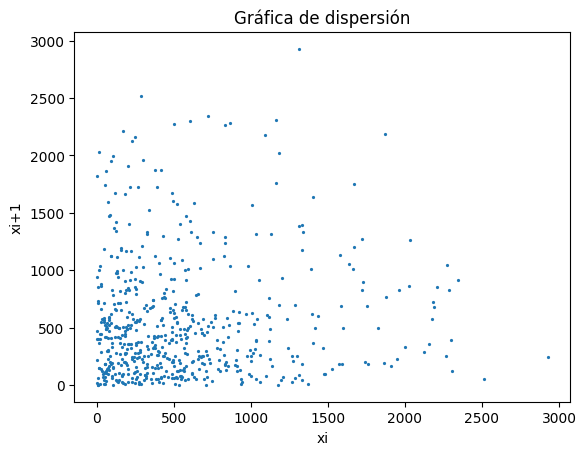

Corridas arriba y abajo
     Co = 396
     Z = 0.3555609247438224
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=270, p=0.06915, U=10804.0, avg=mean(mu1=600.0481481481481, mu2=515.5333333333333))
----------------------------- Bondad de Ajuste -----------------------------


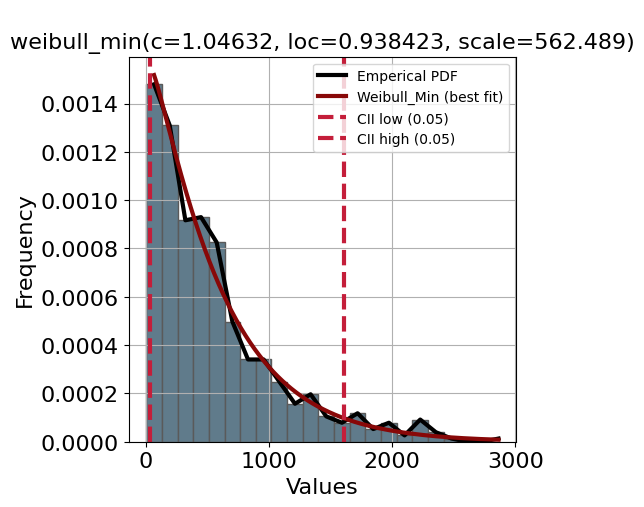

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,weibull_min,0.0,0.938423,562.489154,"(1.0463172912140604,)","(1.0463172912140604, 0.9384233062591238, 562.4...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,genexpon,0.0,0.993093,170.504688,"(0.28448171092829466, 4.895278971290395, 0.001...","(0.28448171092829466, 4.895278971290395, 0.001...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,betaprime,0.0,-0.073807,3783.712041,"(1.1638939893130864, 8.419975249391424)","(1.1638939893130864, 8.419975249391424, -0.073...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,gompertz,0.0,1.0,6681.168997,"(11.16206229989439,)","(11.16206229989439, 0.999999999969877, 6681.16...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,gamma,0.0,0.921415,522.597664,"(1.0574934185047342,)","(1.0574934185047342, 0.921415422890654, 522.59...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,erlang,0.000007,1.0,2.067357,"(0.04181371784266663,)","(0.04181371784266663, 0.9999999999999998, 2.06...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,alpha,0.000007,-0.045987,18.578277,"(2.8776337415252915e-11,)","(2.8776337415252915e-11, -0.04598667708805984,...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000007,2928.0,1.74025,"(0.11098449388888992,)","(0.11098449388888992, 2928.0000000000005, 1.74...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.581371,2.633974,1,"(0.04297154970317062,)","(0.04297154970317062, 2.633974087902054, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 14 ---------------------------
----------------------------- Independencia -----------------------------


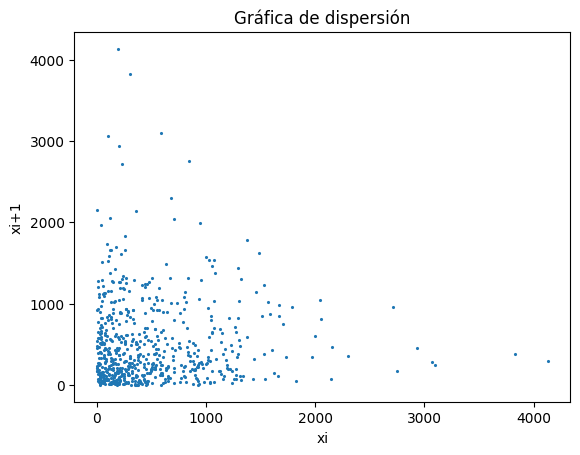

Corridas arriba y abajo
     Co = 421
     Z = 0.6868630688346673
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=97, p=0.5205, U=7483.0, avg=mean(mu1=603.8659793814433, mu2=478.2600732600733))
----------------------------- Bondad de Ajuste -----------------------------


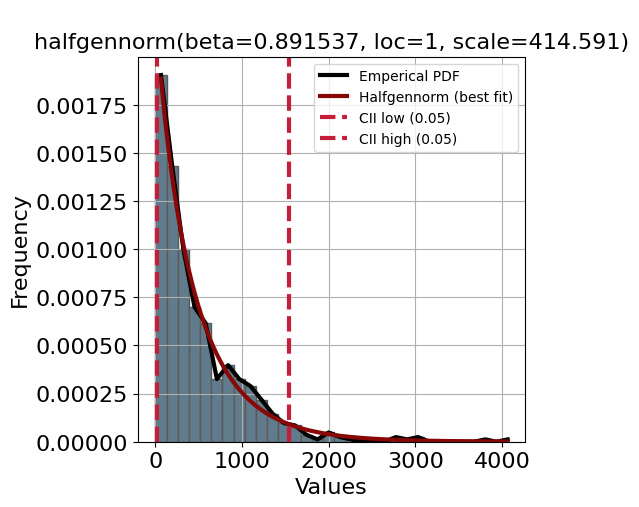

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,halfgennorm,0.0,1.0,414.590991,"(0.8915372068492654,)","(0.8915372068492654, 0.9999999999991946, 414.5...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,weibull_min,0.0,1.0,482.602087,"(0.9364960207411681,)","(0.9364960207411681, 0.9999999999999998, 482.6...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,exponweib,0.0,1.0,474.90377,"(0.9641257381107825, 0.9521005941437306)","(0.9641257381107825, 0.9521005941437306, 0.999...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,betaprime,0.0,0.970146,4258.065788,"(0.9303309204146533, 8.853917797188503)","(0.9303309204146533, 8.853917797188503, 0.9701...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,erlang,0.0,1.0,563.088112,"(0.8848624057876684,)","(0.8848624057876684, 0.9999999999999922, 563.0...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,chi2,0.000008,1.0,2.234821,"(0.06526021112769137,)","(0.06526021112769137, 0.9999999999999998, 2.23...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,gamma,0.000008,1.0,2.24588,"(0.024845431162550217,)","(0.024845431162550217, 0.9999999999999998, 2.2...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000008,4130.0,1.729874,"(0.10322730746346451,)","(0.10322730746346451, 4130.000000000001, 1.729...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.809236,1.423106,1,"(0.033439299730952624,)","(0.033439299730952624, 1.423105880629425, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 15 ---------------------------
----------------------------- Independencia -----------------------------


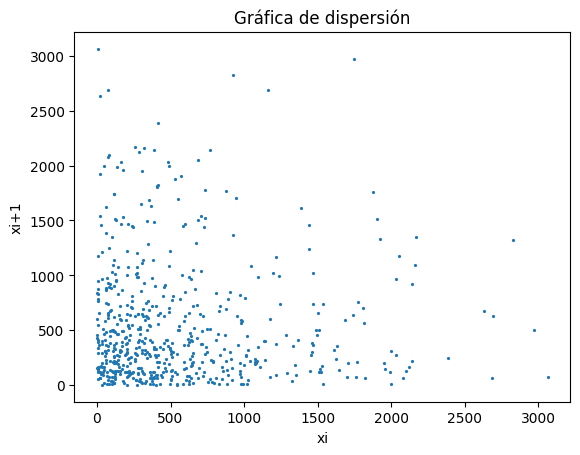

Corridas arriba y abajo
     Co = 401
     Z = 0.12886474889605426
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=281, p=0.5888, U=6456.0, avg=mean(mu1=584.288256227758, mu2=511.6346749226006))
----------------------------- Bondad de Ajuste -----------------------------


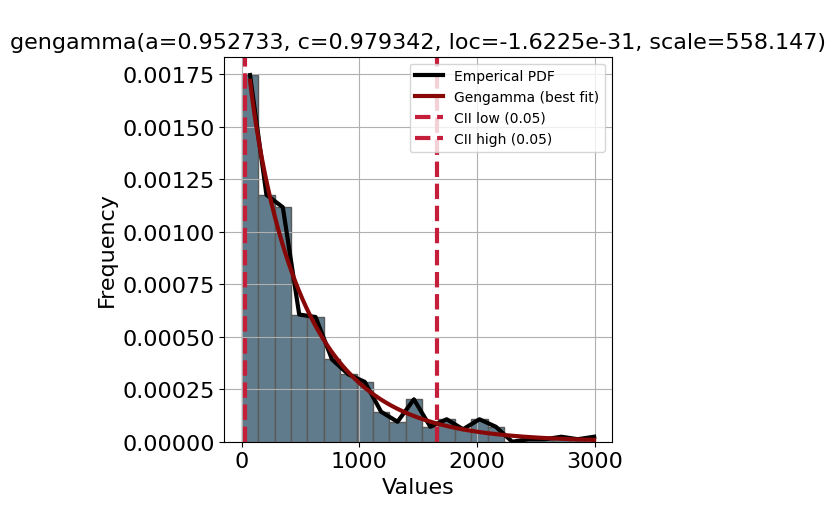

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,gengamma,0.0,-0.0,558.146665,"(0.9527333164421666, 0.9793419414224878)","(0.9527333164421666, 0.9793419414224878, -1.62...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,pearson3,0.0,527.670364,543.874944,"(2.0614193272568775,)","(2.0614193272568775, 527.6703644906806, 543.87...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,exponweib,0.0,-0.0,509.093723,"(1.0502631560960323, 0.9316888971014127)","(1.0502631560960323, 0.9316888971014127, -2.56...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,erlang,0.0,-0.0,596.395659,"(0.9191659030372881,)","(0.9191659030372881, -9.285637162119843e-29, 5...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,gamma,0.0,-0.0,579.278701,"(0.9439157532227391,)","(0.9439157532227391, -5.4340410636297344e-27, ...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,invweibull,0.000006,-5.1492,86.636415,"(0.8352567041443124,)","(0.8352567041443124, -5.149199896807211, 86.63...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,chi2,0.000007,-0.0,2.238248,"(0.05272189975835481,)","(0.05272189975835481, -3.7137409855464126e-24,...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000007,3065.0,1.734909,"(0.11061299511183531,)","(0.11061299511183531, 3065.000000000001, 1.734...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.552138,-0.595762,1,"(0.0853893708141471,)","(0.0853893708141471, -0.595762258522381, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 16 ---------------------------
----------------------------- Independencia -----------------------------


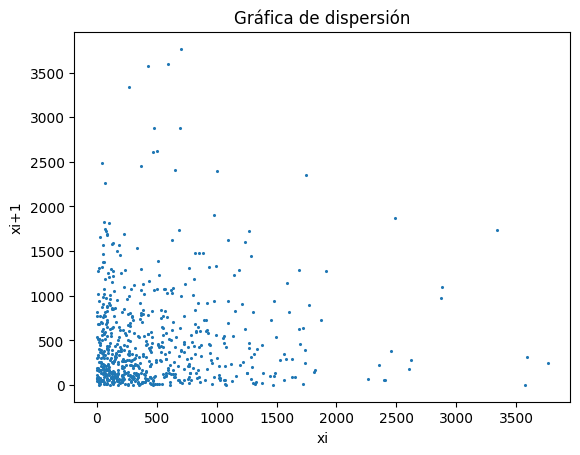

Corridas arriba y abajo
     Co = 446
     Z = 0.4615275379390248
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=506, p=0.1969, U=10345.0, avg=mean(mu1=468.85375494071144, mu2=570.6602564102565))
----------------------------- Bondad de Ajuste -----------------------------


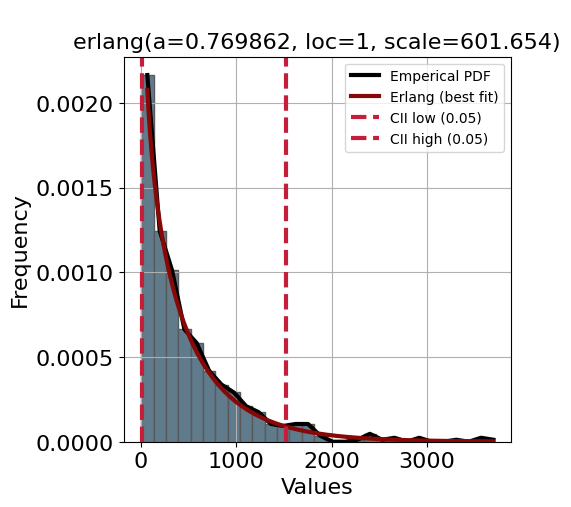

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,erlang,0.0,1.0,601.65409,"(0.7698616540292496,)","(0.7698616540292496, 0.9999999999999997, 601.6...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,recipinvgauss,0.0,-8.897417,379.719415,"(3.1118832301924253,)","(3.1118832301924253, -8.89741686575281, 379.71...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,halfgennorm,0.0,1.0,322.89572,"(0.7853112907981776,)","(0.7853112907981776, 0.999999999756088, 322.89...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,f,0.0,1.0,472.23801,"(1.6718624456763895, 26.356880044478217)","(1.6718624456763895, 26.356880044478217, 0.999...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,weibull_min,0.0,1.0,471.682631,"(0.8996127392218817,)","(0.8996127392218817, 0.9999999999999999, 471.6...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,chi2,0.000009,1.0,2.2374,"(0.05868550686441158,)","(0.05868550686441158, 0.9999999999999998, 2.23...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,gamma,0.000009,1.0,2.247327,"(0.02356531845263517,)","(0.02356531845263517, 0.9999999999999998, 2.24...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000009,3765.0,1.781666,"(0.10859136463335609,)","(0.10859136463335609, 3765.0000000000005, 1.78...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.733018,0.548159,1,"(0.03859762781266323,)","(0.03859762781266323, 0.5481592478815354, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 17 ---------------------------
----------------------------- Independencia -----------------------------


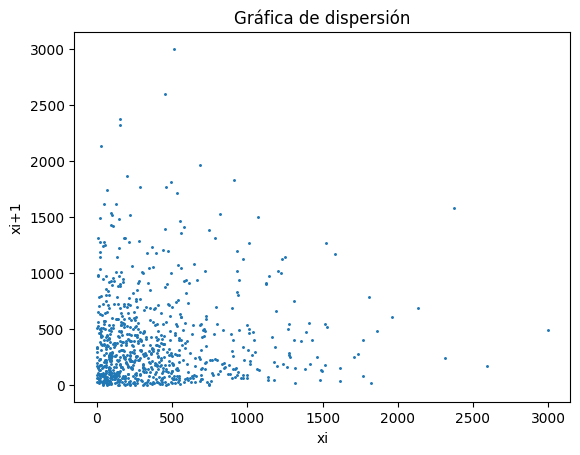

Corridas arriba y abajo
     Co = 551
     Z = 0.33145883252104513
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=485, p=0.0629, U=17770.0, avg=mean(mu1=417.6309278350515, mu2=359.01488095238096))
----------------------------- Bondad de Ajuste -----------------------------


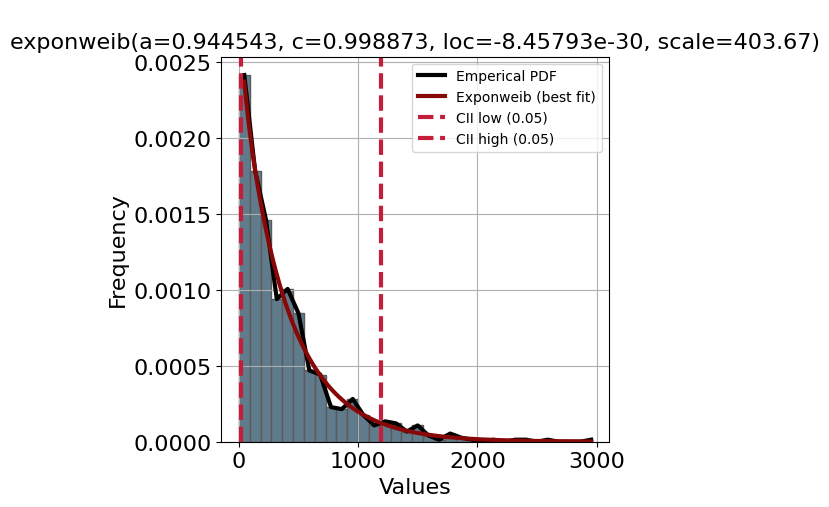

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,exponweib,0.0,-0.0,403.67015,"(0.9445431460090208, 0.9988734353089248)","(0.9445431460090208, 0.9988734353089248, -8.45...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,gamma,0.0,-0.0,414.351298,"(0.9437742962013631,)","(0.9437742962013631, -8.945728345284778e-27, 4...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,halfgennorm,0.0,-0.0,360.67259,"(0.9431232975991564,)","(0.9431232975991564, -4.306654471433891e-12, 3...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,weibull_min,0.0,-0.0,389.268642,"(0.9784976941128936,)","(0.9784976941128936, -5.543708935492903e-27, 3...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,pareto,0.0,-13562.773249,13562.773249,"(35.45337930705349,)","(35.45337930705349, -13562.773248697411, 13562...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,uniform,0.000011,0.0,2998.0,(),"(0.0, 2998.0)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,chi2,0.000014,-0.0,2.226653,"(0.08433265123652611,)","(0.08433265123652611, -6.959480476265506e-23, ...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000015,2998.0,1.737325,"(0.10742715866008329,)","(0.10742715866008329, 2998.000000000001, 1.737...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.832782,-0.083459,1,"(0.014313077630143724,)","(0.014313077630143724, -0.08345939792804025, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 18 ---------------------------
----------------------------- Independencia -----------------------------


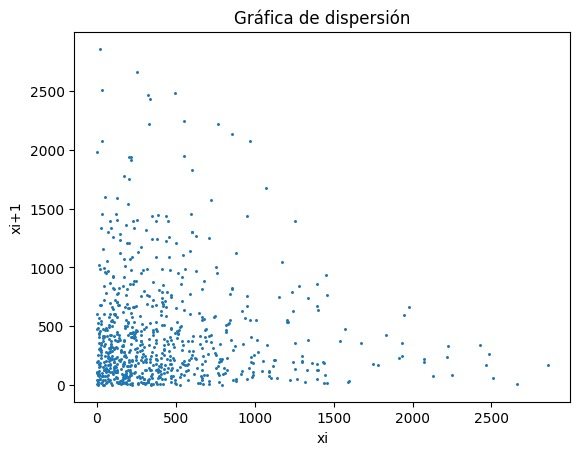

Corridas arriba y abajo
     Co = 510
     Z = 0.19979623020690176
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=102, p=0.14795, U=13811.0, avg=mean(mu1=575.7745098039215, mu2=411.5382308845577))
----------------------------- Bondad de Ajuste -----------------------------


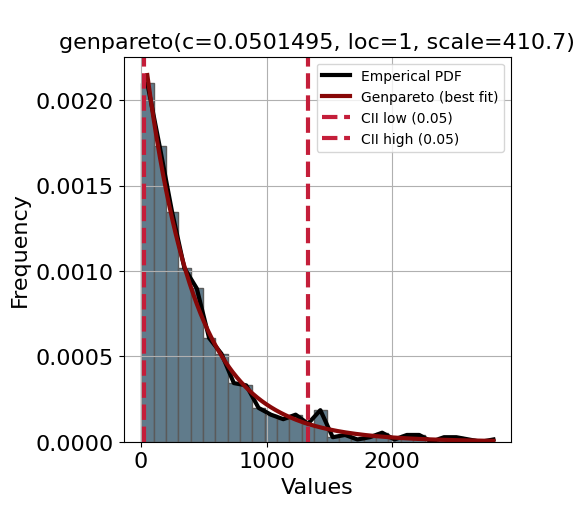

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,genpareto,0.0,1.0,410.700151,"(0.05014949550633943,)","(0.05014949550633943, 0.9999999999996516, 410....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,pareto,0.0,-8188.431165,8189.431165,"(19.940171901730036,)","(19.940171901730036, -8188.431164953703, 8189....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,lomax,0.0,1.0,12356.46752,"(29.495692230945473,)","(29.495692230945473, 0.9999999999918547, 12356...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,betaprime,0.0,0.952808,6278.741684,"(1.0072694909771065, 15.78449794313012)","(1.0072694909771065, 15.78449794313012, 0.9528...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,exponnorm,0.0,0.693876,0.347705,"(1233.797478414352,)","(1233.797478414352, 0.6938760824518249, 0.3477...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,chi2,0.000012,1.0,2.03152,"(0.1905951562856128,)","(0.1905951562856128, 0.9999999999999999, 2.031...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,weibull_max,0.000013,2857.0,1.746674,"(0.1108630085946711,)","(0.1108630085946711, 2857.0000000000005, 1.746...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,alpha,0.000062,-7.229566,69.414349,"(0.8890024393688161,)","(0.8890024393688161, -7.2295657496534815, 69.4...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.734394,-1.093861,1,"(0.04785827275616222,)","(0.04785827275616222, -1.0938605738485272, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 19 ---------------------------
----------------------------- Independencia -----------------------------


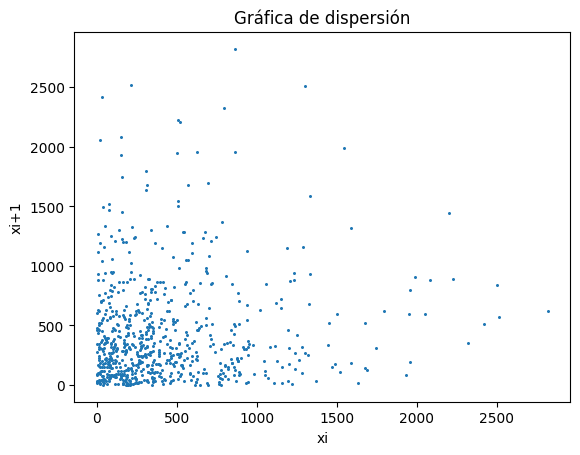

Corridas arriba y abajo
     Co = 485
     Z = 0.17638668718801767
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=True, cp=151, p=0.01995, U=16868.0, avg=mean(mu1=538.225165562914, mu2=407.5853658536585))
----------------------------- Bondad de Ajuste -----------------------------


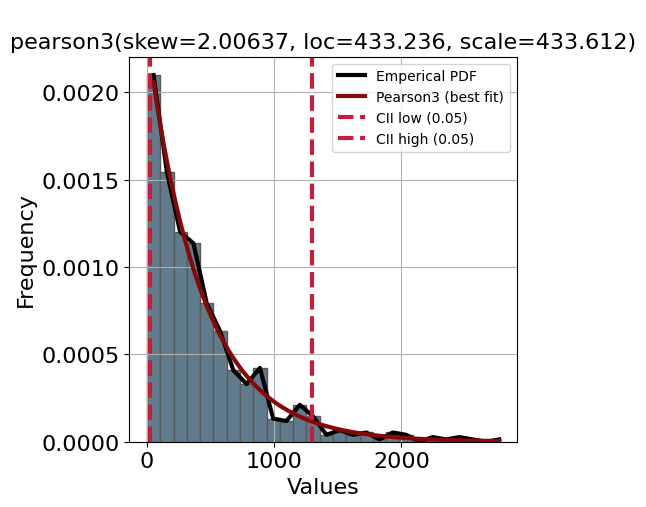

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,pearson3,0.0,433.235956,433.612206,"(2.0063680517180735,)","(2.0063680517180735, 433.2359558527927, 433.61...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,exponnorm,0.0,0.638568,0.487545,"(884.1084523136819,)","(884.1084523136819, 0.6385676706572774, 0.4875...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,halfgennorm,0.0,1.0,420.539948,"(0.9788012353441853,)","(0.9788012353441853, 0.9999999999998779, 420.5...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,gengamma,0.0,1.0,495.123591,"(0.8875988320383067, 1.047000301009257)","(0.8875988320383067, 1.047000301009257, 0.9999...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,pareto,0.0,-43088.090713,43089.090713,"(100.33035463913838,)","(100.33035463913838, -43088.09071314619, 43089...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,alpha,0.000008,-0.03059,14.394124,"(3.2893145450496755e-11,)","(3.2893145450496755e-11, -0.030590067055339044...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,chi2,0.000011,1.0,2.03171,"(0.18991873297923195,)","(0.18991873297923195, 0.9999999999999999, 2.03...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000011,2821.0,1.746915,"(0.11069600628470988,)","(0.11069600628470988, 2821.0000000000005, 1.74...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.681802,1.904935,1,"(0.0598573477826249,)","(0.0598573477826249, 1.9049350777677176, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Hora: 20 ---------------------------
----------------------------- Independencia -----------------------------


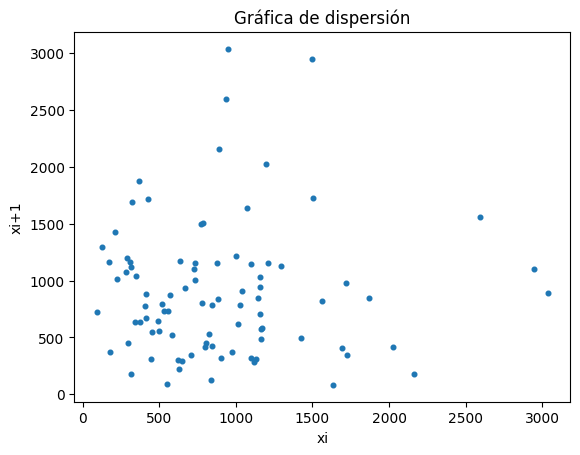

Corridas arriba y abajo
     Co = 57
     Z = 0.6734827555106613
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=41, p=0.22465, U=491.0, avg=mean(mu1=1047.439024390244, mu2=758.8979591836735))
----------------------------- Bondad de Ajuste -----------------------------


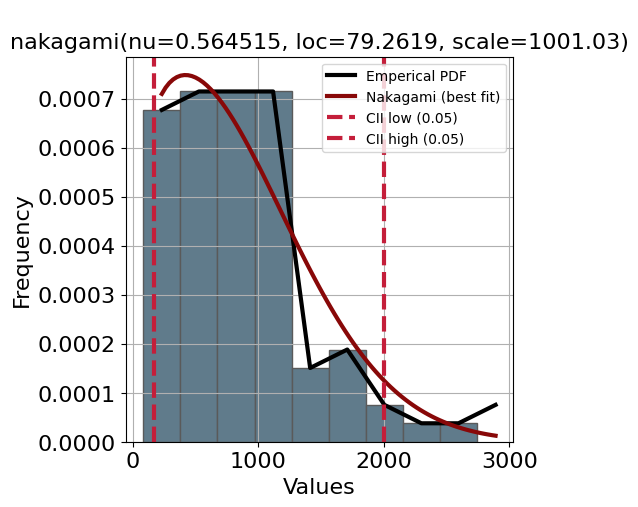

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,nakagami,0.0,79.261882,1001.026126,"(0.5645151251008058,)","(0.5645151251008058, 79.26188197182836, 1001.0...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,burr,0.0,-4.956878,1119.661982,"(3.683257988015825, 0.4526310233758396)","(3.683257988015825, 0.4526310233758396, -4.956...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,gausshyper,0.0,39.51118,21258.880387,"(1.9774267837773518, 41.34724489318788, -8.988...","(1.9774267837773518, 41.34724489318788, -8.988...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,beta,0.0,39.732623,22072.929246,"(1.975919865794442, 49.298952642045705)","(1.975919865794442, 49.298952642045705, 39.732...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,mielke,0.0,-11.195672,1113.463405,"(1.7046762568190452, 3.6664916476606724)","(1.7046762568190452, 3.6664916476606724, -11.1...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,invweibull,0.000001,81.997162,2.837745,"(0.23851706504465503,)","(0.23851706504465503, 81.99716203374197, 2.837...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,weibull_max,0.000002,3037.0,1.731241,"(0.1075941426313669,)","(0.1075941426313669, 3037.0000000000005, 1.731...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,chi2,0.000002,82.0,4.464812,"(0.0430222741099618,)","(0.0430222741099618, 81.99999999999999, 4.4648...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.207752,0.50667,1,"(0.15197775180764764,)","(0.15197775180764764, 0.5066702729416375, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


In [6]:
horas = [x for x in range(6, 21)]
# get only the hours from 'llegada' column
distri = {}
__data__ = pd.DataFrame()
for hora in horas:
    __data__ = data[data["hora_llegada"] == hora]["num_entre_llegadas"]
    print(f"---------------------- Hora: {hora} ---------------------------")
    print(f"----------------------------- Independencia -----------------------------")
    scatter_plot(__data__.values)
    corridas_arriba_y_abajo(__data__.values)
    print(f"----------------------------- Homogeneidad -----------------------------")
    print("Pettitt Test")
    print(pettitt_test(__data__))    
    print(f"----------------------------- Bondad de Ajuste -----------------------------")
    dist = distfit(verbose = 0, distr='full')
    dist.fit_transform(__data__)
    dist.plot(figsize=(5,5))
    plt.show()
    display(dist.summary)
    distri[hora] = dist.summary  


In [7]:
# Write distri to an excel file, where hora in horas is the sheet name and the summary is the content, make all the sheets in one excel file
with pd.ExcelWriter('data/distri.xlsx') as writer:
    for hora in horas:
        distri[hora].to_excel(writer, sheet_name=str(hora))

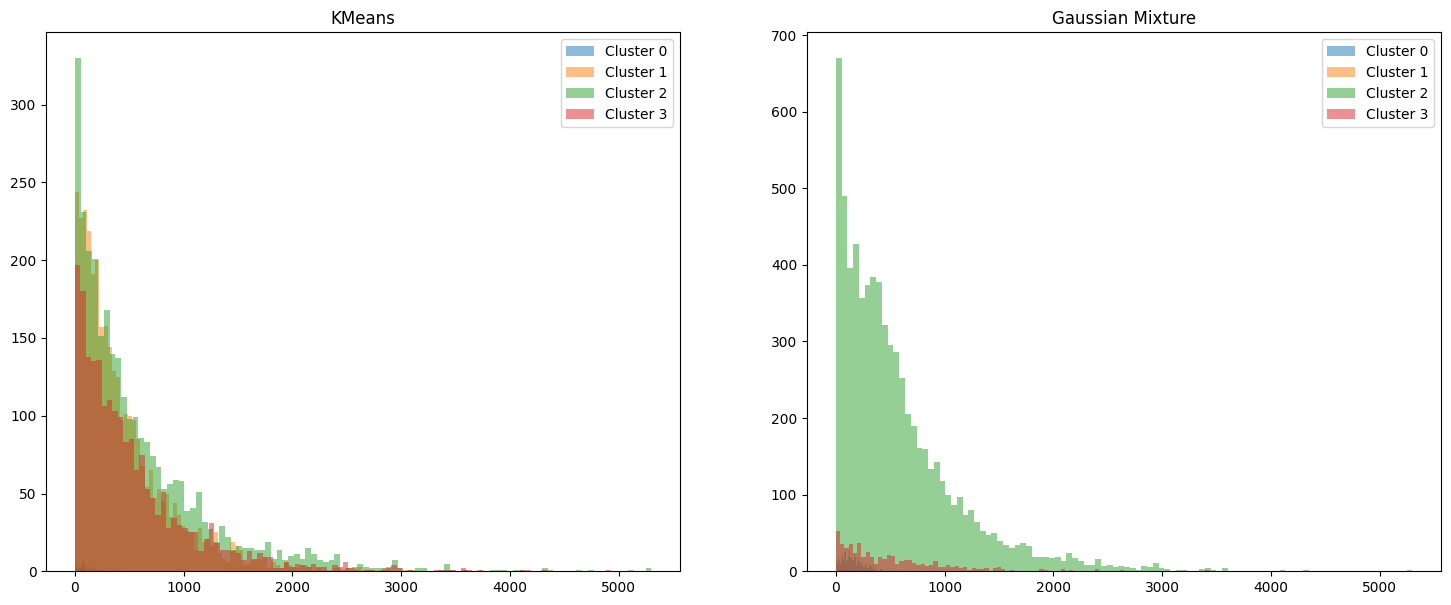

In [8]:
# Take data['num_entre_llegadas'] and make clusters using KMeans and GaussianMixture and save the clusters in data['cluster_kmenas'] and data['cluster_gaussian']
# use the following columns to make the clusters
#  13  dia_mes             8666 non-null   int64          
#  14  num_espera          8666 non-null   int64          
#  15  num_duracion        8666 non-null   int64          
#  16  num_entre_llegadas  8666 non-null   int64          
#  17  num_llegada         8666 non-null   float64        
#  18  hora_llegada        8666 non-null   float64        
#  19  num_estado          8666 non-null   int64          
#  20  num_dia_semana      8666 non-null   int64          
#  21  num_mes             8666 non-null   int64          
#  22  num_tiposerv.       8666 non-null   int64   
# and save the models in kmeans and gaussian respectively, and plot the clusters side by side

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# get the columns to make the clusters
columns = data.columns[13:23]
# get the data to make the clusters
X = data[columns]
# scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n = 4 # number of clusters
# make the clusters using KMeans
kmeans = KMeans(n_clusters=n, random_state=0).fit(X_scaled)
# make the clusters using GaussianMixture
gaussian = GaussianMixture(n_components=n, random_state=0).fit(X_scaled)

# save the clusters in data['cluster_kmenas'] and data['cluster_gaussian']
data['cluster_kmeans'] = kmeans.predict(X_scaled)
data['cluster_gaussian'] = gaussian.predict(X_scaled)

# plot the clusters side by side as histograms colored by the cluster
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
# plot the clusters from KMeans
for i in range(n):
    ax1.hist(data[data['cluster_kmeans'] == i]['num_entre_llegadas'], bins=100, alpha=0.5, label=f'Cluster {i}')
ax1.set_title('KMeans')
ax1.legend()
# plot the clusters from GaussianMixture
for i in range(n):
    ax2.hist(data[data['cluster_gaussian'] == i]['num_entre_llegadas'], bins=100, alpha=0.5, label=f'Cluster {i}')
ax2.set_title('Gaussian Mixture')
ax2.legend()
plt.show()


In [9]:
# Check for kmeans and for gaussian if the clusters are homogeneous using Pettitt Test
print("KMeans")
for i in range(n):
    print(f"Cluster {i}")
    print(pettitt_test(data[data['cluster_kmeans'] == i]['num_entre_llegadas']))
print("Gaussian")
for i in range(n):
    print(f"Cluster {i}")
    print(pettitt_test(data[data['cluster_gaussian'] == i]['num_entre_llegadas']))

KMeans
Cluster 0
Pettitt_Test(h=False, cp=108, p=0.49465, U=1178.0, avg=mean(mu1=89.24074074074075, mu2=77.5875))
Cluster 1
Pettitt_Test(h=True, cp=1521, p=0.01075, U=183122.0, avg=mean(mu1=480.54700854700855, mu2=439.79026217228466))
Cluster 2
Pettitt_Test(h=False, cp=411, p=0.07455, U=118023.0, avg=mean(mu1=712.5815085158151, mu2=579.5212765957447))
Cluster 3
Pettitt_Test(h=False, cp=1024, p=0.1093, U=68568.0, avg=mean(mu1=589.646484375, mu2=508.67713004484307))
Gaussian
Cluster 0
Pettitt_Test(h=False, cp=464, p=0.8005, U=11724.0, avg=mean(mu1=161.6875, mu2=151.5018115942029))
Cluster 1
Pettitt_Test(h=False, cp=107, p=0.46815, U=1197.0, avg=mean(mu1=89.71028037383178, mu2=77.5875))
Cluster 2
Pettitt_Test(h=False, cp=4934, p=0.1156, U=391566.0, avg=mean(mu1=569.6503850830969, mu2=617.6035714285714))
Cluster 3
Pettitt_Test(h=False, cp=278, p=0.06655, U=10051.0, avg=mean(mu1=607.8237410071943, mu2=476.98625429553266))


---------------------- Cluster: 0 ---------------------------
----------------------------- Independencia -----------------------------


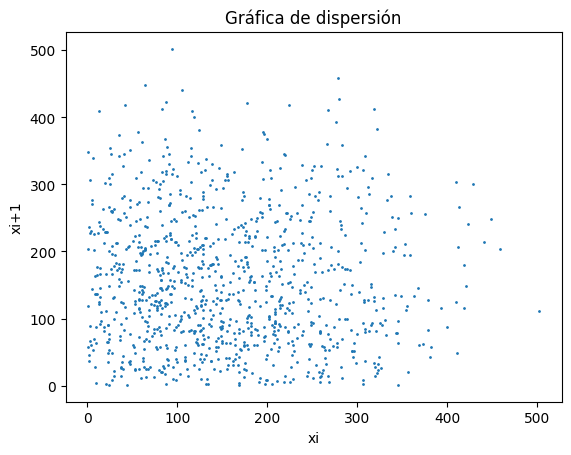

Corridas arriba y abajo
     Co = 691
     Z = 1.0426298929786484
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=464, p=0.80255, U=11724.0, avg=mean(mu1=161.6875, mu2=151.5018115942029))
----------------------------- Bondad de Ajuste -----------------------------


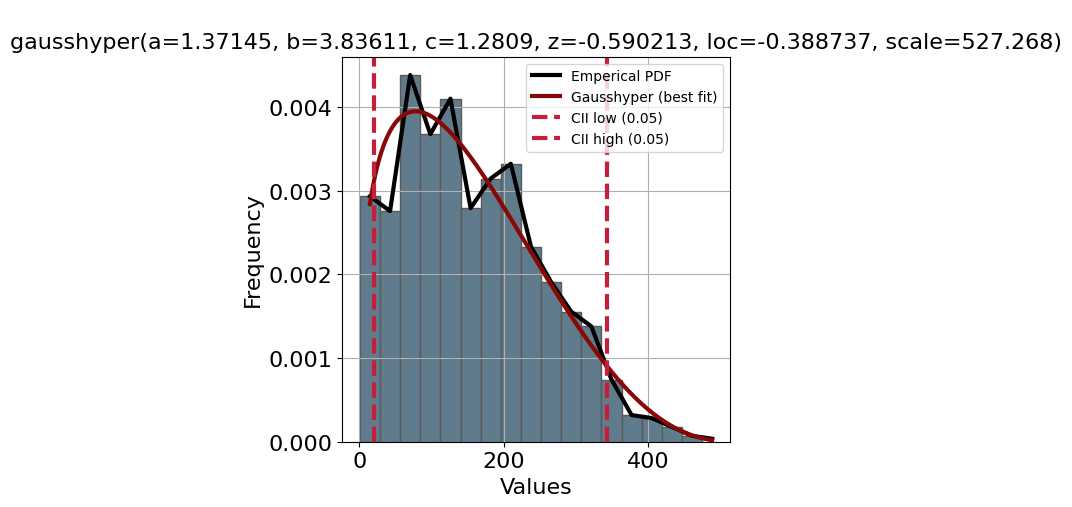

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,gausshyper,0.000002,-0.388737,527.267978,"(1.3714531535104042, 3.8361056247392593, 1.280...","(1.3714531535104042, 3.8361056247392593, 1.280...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,beta,0.000002,-0.809577,524.004807,"(1.4222024548848093, 3.3520723907143157)","(1.4222024548848093, 3.3520723907143157, -0.80...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,nakagami,0.000003,-0.273168,184.525195,"(0.662611354848191,)","(0.662611354848191, -0.2731675680317284, 184.5...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,genhalflogistic,0.000003,1.0,147.309697,"(0.2756569581438143,)","(0.2756569581438143, 0.9999999996718947, 147.3...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,burr,0.000003,0.088718,280.650104,"(6.975264387686202, 0.1555308078578913)","(6.975264387686202, 0.1555308078578913, 0.0887...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,weibull_max,0.000117,502.0,1.704047,"(0.15455627282453938,)","(0.15455627282453938, 502.0000000000001, 1.704...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,gompertz,0.000871,298.999932,10.777721,"(6.401421402380699e-07,)","(6.401421402380699e-07, 298.9999318858121, 10....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,alpha,0.000918,-0.030572,13.622543,"(5.596457339340731e-11,)","(5.596457339340731e-11, -0.03057235588137136, ...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.443393,-0.388225,1,"(0.0670814353227911,)","(0.0670814353227911, -0.3882248564560413, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Cluster: 1 ---------------------------
----------------------------- Independencia -----------------------------


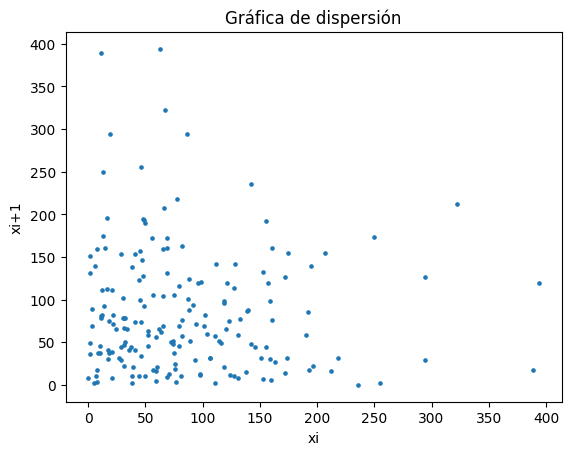

Corridas arriba y abajo
     Co = 128
     Z = 0.6390382581475923
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=107, p=0.47, U=1197.0, avg=mean(mu1=89.71028037383178, mu2=77.5875))
----------------------------- Bondad de Ajuste -----------------------------


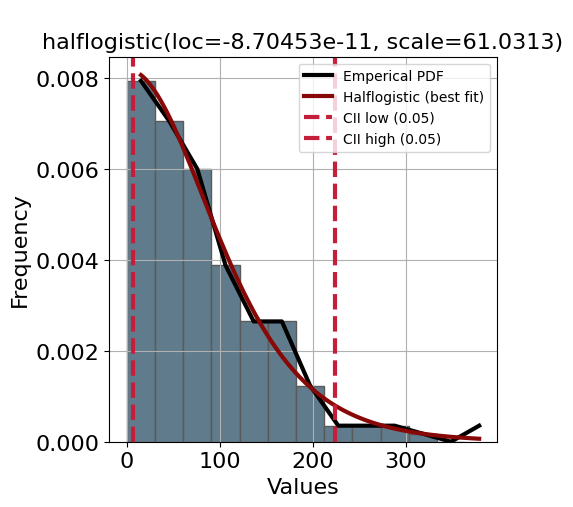

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,halflogistic,0.000001,-0.0,61.031308,(),"(-8.704525360428872e-11, 61.031308377560904)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,genhalflogistic,0.000001,-0.0,60.962649,"(3.498372024935306e-08,)","(3.498372024935306e-08, -2.695368273182186e-07...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,gompertz,0.000002,-0.02093,259.669263,"(2.203001333029916,)","(2.203001333029916, -0.020930129430063338, 259...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,weibull_min,0.000002,-0.139817,89.026849,"(1.1583194184867605,)","(1.1583194184867605, -0.13981683153731028, 89....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,exponweib,0.000002,-0.0,113.573192,"(0.6828754352487096, 1.407558408390409)","(0.6828754352487096, 1.407558408390409, -2.992...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,chi2,0.000171,-0.0,2.092941,"(0.4537500950267481,)","(0.4537500950267481, -2.1697815451845915e-24, ...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,erlang,0.000179,-0.0,2.144698,"(0.3115261897872821,)","(0.3115261897872821, -3.620529843246496e-24, 2...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000183,394.0,1.608826,"(0.15294723482806372,)","(0.15294723482806372, 394.0000000000001, 1.608...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.314184,-0.535681,1,"(0.09118350223253752,)","(0.09118350223253752, -0.5356806353729748, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Cluster: 2 ---------------------------
----------------------------- Independencia -----------------------------


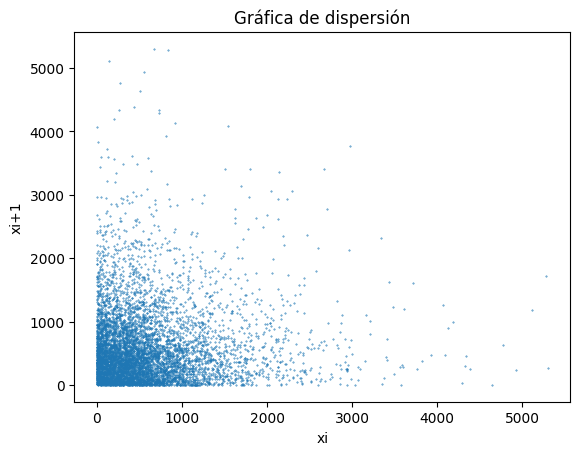

Corridas arriba y abajo
     Co = 4664
     Z = 1.9521596316351917
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=4934, p=0.11945, U=391566.0, avg=mean(mu1=569.6503850830969, mu2=617.6035714285714))
----------------------------- Bondad de Ajuste -----------------------------


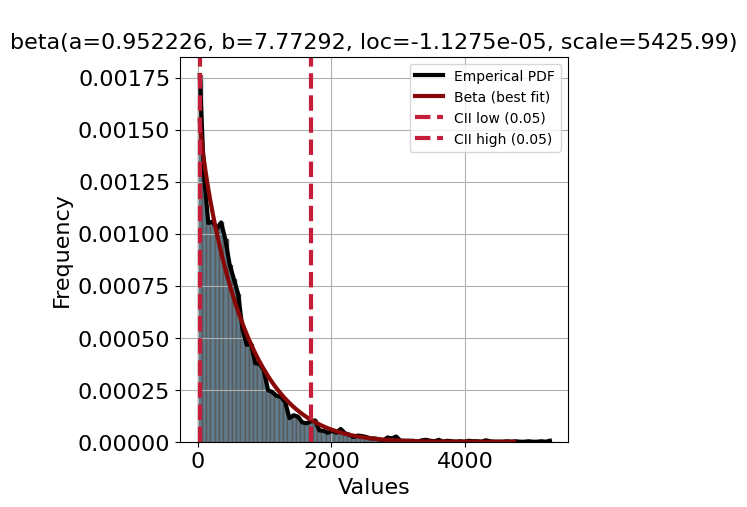

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,beta,0.0,-0.000011,5425.991145,"(0.9522260492179202, 7.772915713217948)","(0.9522260492179202, 7.772915713217948, -1.127...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,gengamma,0.0,-0.0,1044.378842,"(0.5335031756595315, 1.4322434848057315)","(0.5335031756595315, 1.4322434848057315, -3.70...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,halfgennorm,0.0,-0.0,599.615399,"(1.0199241584150158,)","(1.0199241584150158, -1.5436593294828152e-12, ...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,gompertz,0.0,-0.0,620478047731.753052,"(1063536548.9258158,)","(1063536548.9258158, -1.0028082619274486e-11, ...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,expon,0.0,0.0,583.283725,(),"(0.0, 583.2837249782419)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,lognorm,0.000012,-0.0,0.029353,"(83.28270165154422,)","(83.28270165154422, -5e-324, 0.02935265823768579)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,weibull_max,0.000015,5301.0,1.722506,"(0.10168030909245557,)","(0.10168030909245557, 5301.000000000001, 1.722...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,vonmises,2.096444,-0.306159,1,"(0.025015942671074095,)","(0.025015942671074095, -0.3061589774709006, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,mielke,NaN,-421.712438,69.54922,"(813.1778306431054, 2.49978137640663)","(813.1778306431054, 2.49978137640663, -421.712...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


---------------------- Cluster: 3 ---------------------------
----------------------------- Independencia -----------------------------


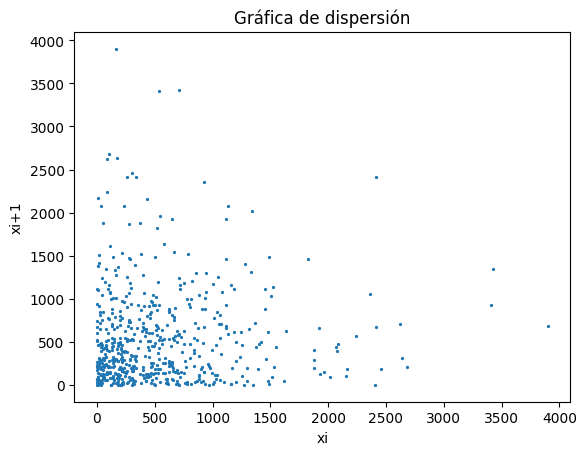

Corridas arriba y abajo
     Co = 372
     Z = 0.6971014368247569
        Z0.05 = 1.959963984540054
     H0: Los números son independientes
     H1: Los números no son independientes
     ----Se acepta H0----
----------------------------- Homogeneidad -----------------------------
Pettitt Test
Pettitt_Test(h=False, cp=278, p=0.06445, U=10051.0, avg=mean(mu1=607.8237410071943, mu2=476.98625429553266))
----------------------------- Bondad de Ajuste -----------------------------


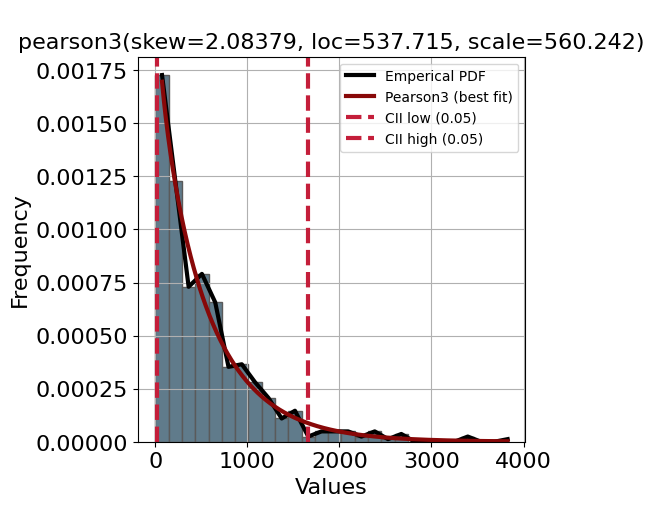

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,pearson3,0.0,537.714595,560.241848,"(2.083788884653142,)","(2.083788884653142, 537.7145952966478, 560.241...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,halfgennorm,0.0,-0.0,468.860906,"(0.9111196789398651,)","(0.9111196789398651, -5.858906257502762e-11, 4...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,pareto,0.0,-17738.784549,17738.784549,"(33.79323035683258,)","(33.79323035683258, -17738.78454884344, 17738....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
3,gengamma,0.0,-0.0,650.9691,"(0.821009250203797, 0.9943982149245254)","(0.821009250203797, 0.9943982149245254, -3.512...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
4,exponweib,0.0,-0.0,561.907862,"(0.983875305275161, 0.8861581866147903)","(0.983875305275161, 0.8861581866147903, -3.590...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
...,...,...,...,...,...,...,...,...,...,...
75,alpha,0.000005,-1.51925,2.979399,"(1.6880381370609298e-10,)","(1.6880381370609298e-10, -1.5192503995324307, ...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
76,lognorm,0.000006,-0.0,0.002111,"(93.60333325098509,)","(93.60333325098509, -5e-324, 0.002111236410766...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
77,weibull_max,0.000007,3900.0,1.74319,"(0.10464342123026493,)","(0.10464342123026493, 3900.000000000001, 1.743...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999
78,vonmises,0.588402,-1.295003,1,"(0.08915843235189894,)","(0.08915843235189894, -1.295003079504582, 1)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


In [10]:
# For the gaussian clusters, get the distribution for each cluster and save it in distri_gaussian
distri_gaussian = {}
__data__ = pd.DataFrame()
for i in range(n):
    __data__ = data[data['cluster_gaussian'] == i]['num_entre_llegadas']
    print(f"---------------------- Cluster: {i} ---------------------------")
    print(f"----------------------------- Independencia -----------------------------")
    scatter_plot(__data__.values)
    corridas_arriba_y_abajo(__data__.values)
    print(f"----------------------------- Homogeneidad -----------------------------")
    print("Pettitt Test")
    print(pettitt_test(__data__))    
    print(f"----------------------------- Bondad de Ajuste -----------------------------")
    dist = distfit(verbose = 0, distr='full')
    dist.fit_transform(__data__)
    dist.plot(figsize=(5,5))
    plt.show()
    display(dist.summary)
    distri_gaussian[i] = dist.summary

In [11]:
# Save the distributions for each cluster in an excel file, where the sheet name is the cluster and the content is the summary
with pd.ExcelWriter('data/distri_gaussian.xlsx') as writer:
    for i in range(n):
        distri_gaussian[i].to_excel(writer, sheet_name=str(i))

In [12]:
# write data to an excel file
data.to_excel('data/data.xlsx')

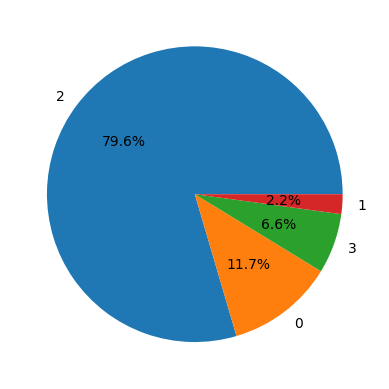

In [13]:
# get a plot with the porcentual of each cluster
plt.pie(data['cluster_gaussian'].value_counts().values, labels=data['cluster_gaussian'].value_counts().index, autopct='%1.1f%%');